In [1]:
import nibabel as nib
import torch
from torch.nn import functional as F
from matplotlib import pyplot as plt
from tqdm import tqdm 
import kornia as K
from plotting import plt_images_2,plot_3d_svf

import os
os.environ['NEURITE_BACKEND'] = 'pytorch'
import neurite as ne
import layers
from Regularization import TVRegulariser

In [2]:
device_type = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_type)
if device_type == 'cuda':
    print('GPU: ' + torch.cuda.get_device_name(0) + ', CUDA: ' + str(torch.cuda.is_available()))
else:
    print('CPU')

GPU: Quadro RTX 6000, CUDA: True


In [3]:
file1 = '/its/home/pi58/data/ExBox20/nodif.nii.gz'
file2 = '/its/home/pi58/data/ExBox20/nodif_PA.nii.gz'

img_pos = torch.tensor(nib.load(file1).get_fdata()).double().to(device)
img_inv = torch.tensor(nib.load(file2).get_fdata()).double().to(device)


#Rotating as the images are rotated. Need to do this irrespective of environment/library being used
img_pos = torch.rot90(img_pos, 1,[0,1])
img_inv = torch.rot90(img_inv, 1,[0,1])



img_pos = img_pos.permute(2,0,1) # making it (D,H,W) for kornia
img_inv = img_inv.permute(2,0,1)
img_pos = img_pos[None,:,:,:] #Adding (B,*spatial) additional 2 dimensions for kornia
img_inv = img_inv[None,:,:,:]


print("img_pos : ",img_pos.shape, "\n", "img_inv : ",img_inv.shape)


img_pos_pyramid = K.geometry.transform.build_pyramid(img_pos, 4)
img_inv_pyramid = K.geometry.transform.build_pyramid(img_inv, 4)
print("0 : ",img_pos_pyramid[0].shape, "\n", "-1 : ",img_pos_pyramid[-1].shape)

img_pos :  torch.Size([1, 76, 116, 116]) 
 img_inv :  torch.Size([1, 76, 116, 116])
0 :  torch.Size([1, 76, 116, 116]) 
 -1 :  torch.Size([1, 76, 14, 14])


Testing Pyramids

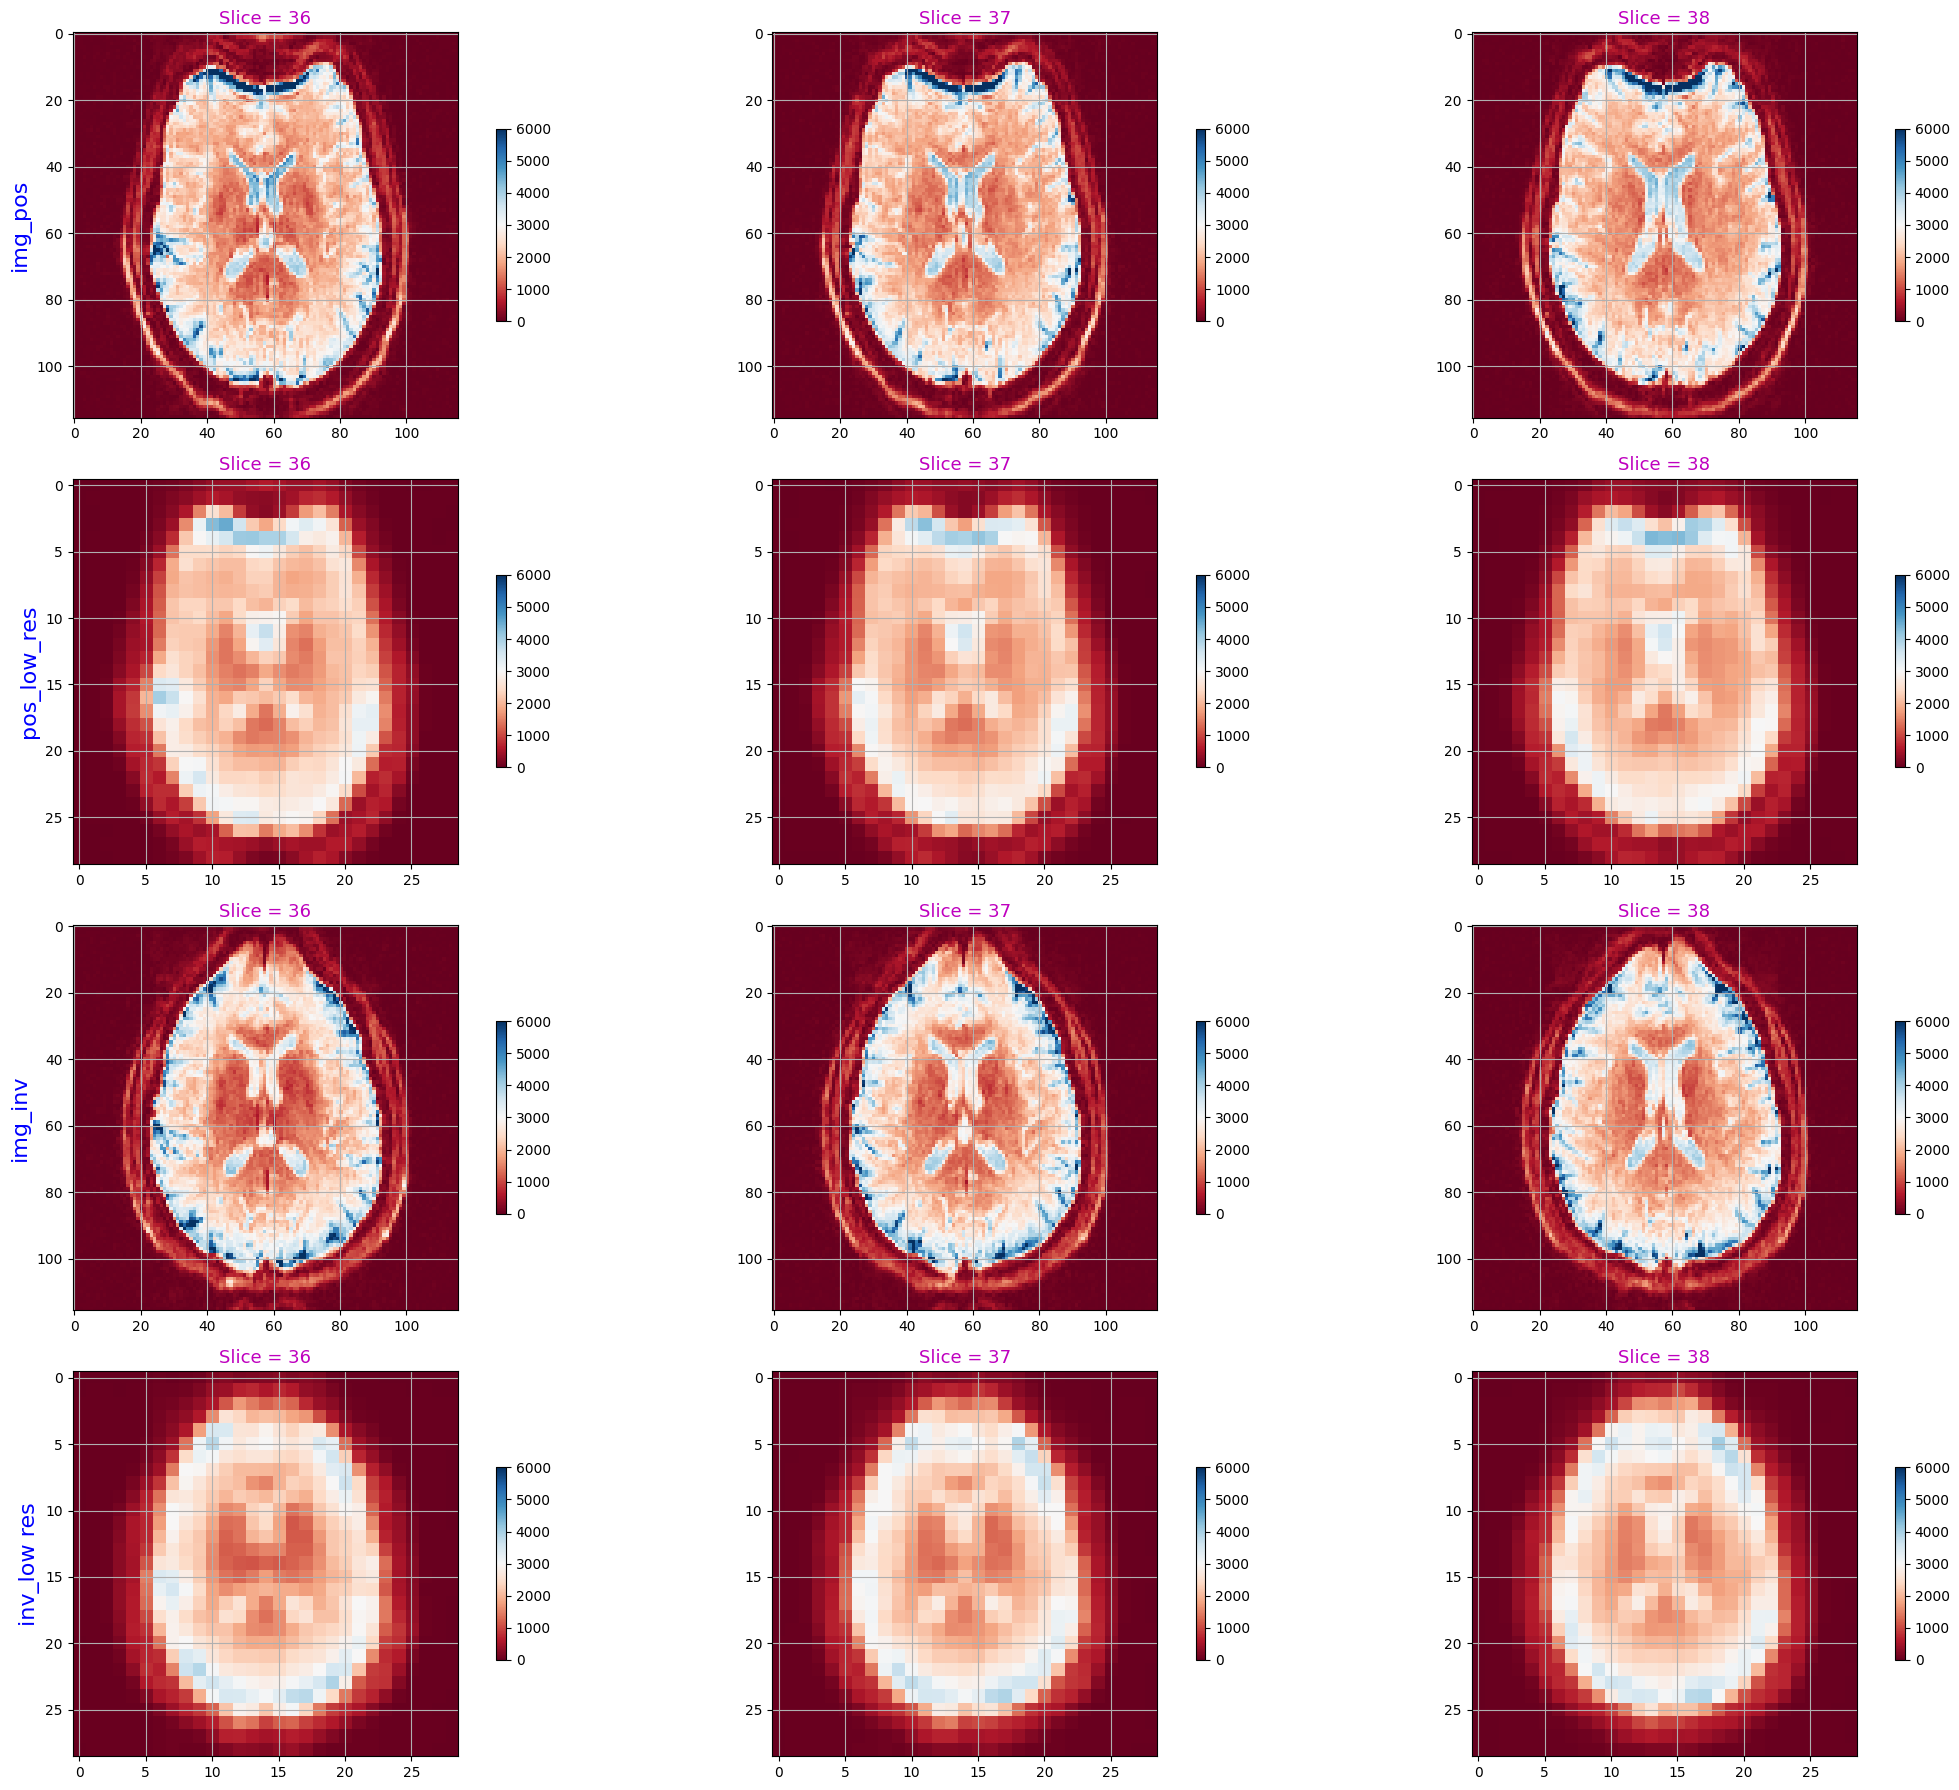

In [4]:
vmax_list = [6000,6000,6000,6000,6000,1,1]
v_list = ["img_pos", "pos_low_res" , "img_inv", "inv_low res"]
h_list = ["magnitude", "magnitude", "magnitude", "magnitude"]
slices = [36,37,38]
z = [img_pos, img_pos_pyramid[-2], img_inv, img_inv_pyramid[-2]]
plt_images_2(slices,z,v_list,h_list,vmax_list)

In [4]:
#Initializations
template_img = (img_pos_pyramid[-1] + img_inv_pyramid[-1])/2
# grid = spatial.identity_grid((template_img.shape[0],template_img.shape[1],template_img.shape[2]), device=template_img.device, dtype=template_img.dtype)
# grid = spatial.identity_grid((template_img.shape[0],template_img.shape[1],template_img.shape[2]), device=template_img.device, dtype=template_img.dtype)

grid = torch.ones((template_img.shape[0],3,template_img.shape[1],template_img.shape[2],template_img.shape[3]),requires_grad=True,device=device)
grid = torch.nn.Parameter(grid)
template_img = torch.nn.Parameter(template_img[None,].float())
loss = torch.nn.GaussianNLLLoss()
# reg = TVRegulariser(pixel_spacing=[8,8,8]) #larger pixel spacing will lead to stronger reg effect
reg = K.losses.TotalVariation()
losses = {0:[],1:[],2:[],3:[],4:[]}

# transformation = SVFTransfromation()

epochs = 150
learning_rate = 0.8
vmax_list = [6000,6000,6000,6000,6000,1,1]
v_list = ["warped_pos", "img_pos", "warped_inv", "img_inv","template_img","jac","ijac"]
h_list = ["magnitude", "magnitude", "magnitude", "magnitude","magnitude","log","log"]
slices = [36,37,38]
print(grid.shape,template_img.shape)

torch.Size([1, 3, 76, 14, 14]) torch.Size([1, 1, 76, 14, 14])


Checking inverse

In [6]:
from IPython.display import clear_output

def forward_model(template_img,grid):
    '''
    Expected shape : template (1,d,h,w)
    Expected shape : grid (1,3,d,h,w)
    '''

    template_img = template_img.to(device)
    grid = grid.to(device)
    spatial_dims = (template_img.shape[2],template_img.shape[3],template_img.shape[4]) #(d,h,w)
    # print(spatial_dims)
    
    # grid = -grid if(inv) else grid
    exp = layers.VecInt(device, spatial_dims, 4)
    disp = exp(grid) #input grid and output displacement field shape (1,3,*spatial)
    jac_det = layers.jacobian_determinant((disp).cpu())
    jac_det = (torch.from_numpy(jac_det)).to(device) 
    # template_img = template_img * jac_det #jacobian modulation
    temp = template_img.clone()
    transformer = layers.SpatialTransformer(device, spatial_dims)
    warped = transformer.forward(template_img.float(),disp)
    # jac_det = transformer.forward(jac_det.unsqueeze(0).unsqueeze(0).float(),grid)
    # warped = warped.squeeze(0).squeeze(0) * (jac_det.squeeze(0).squeeze(0))
    #returning shape (1,*spatial) and jacdet(*spatial)
    # return warped.unsqueeze(0).unsqueeze(0).to(torch.float64), jac_det.squeeze(0).squeeze(0)
    return warped.to(torch.float64), jac_det



torch.Size([1, 1, 76, 116, 116])


/its/home/pi58/anaconda3/envs/mri_recon/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([1, 1, 76, 116, 116])


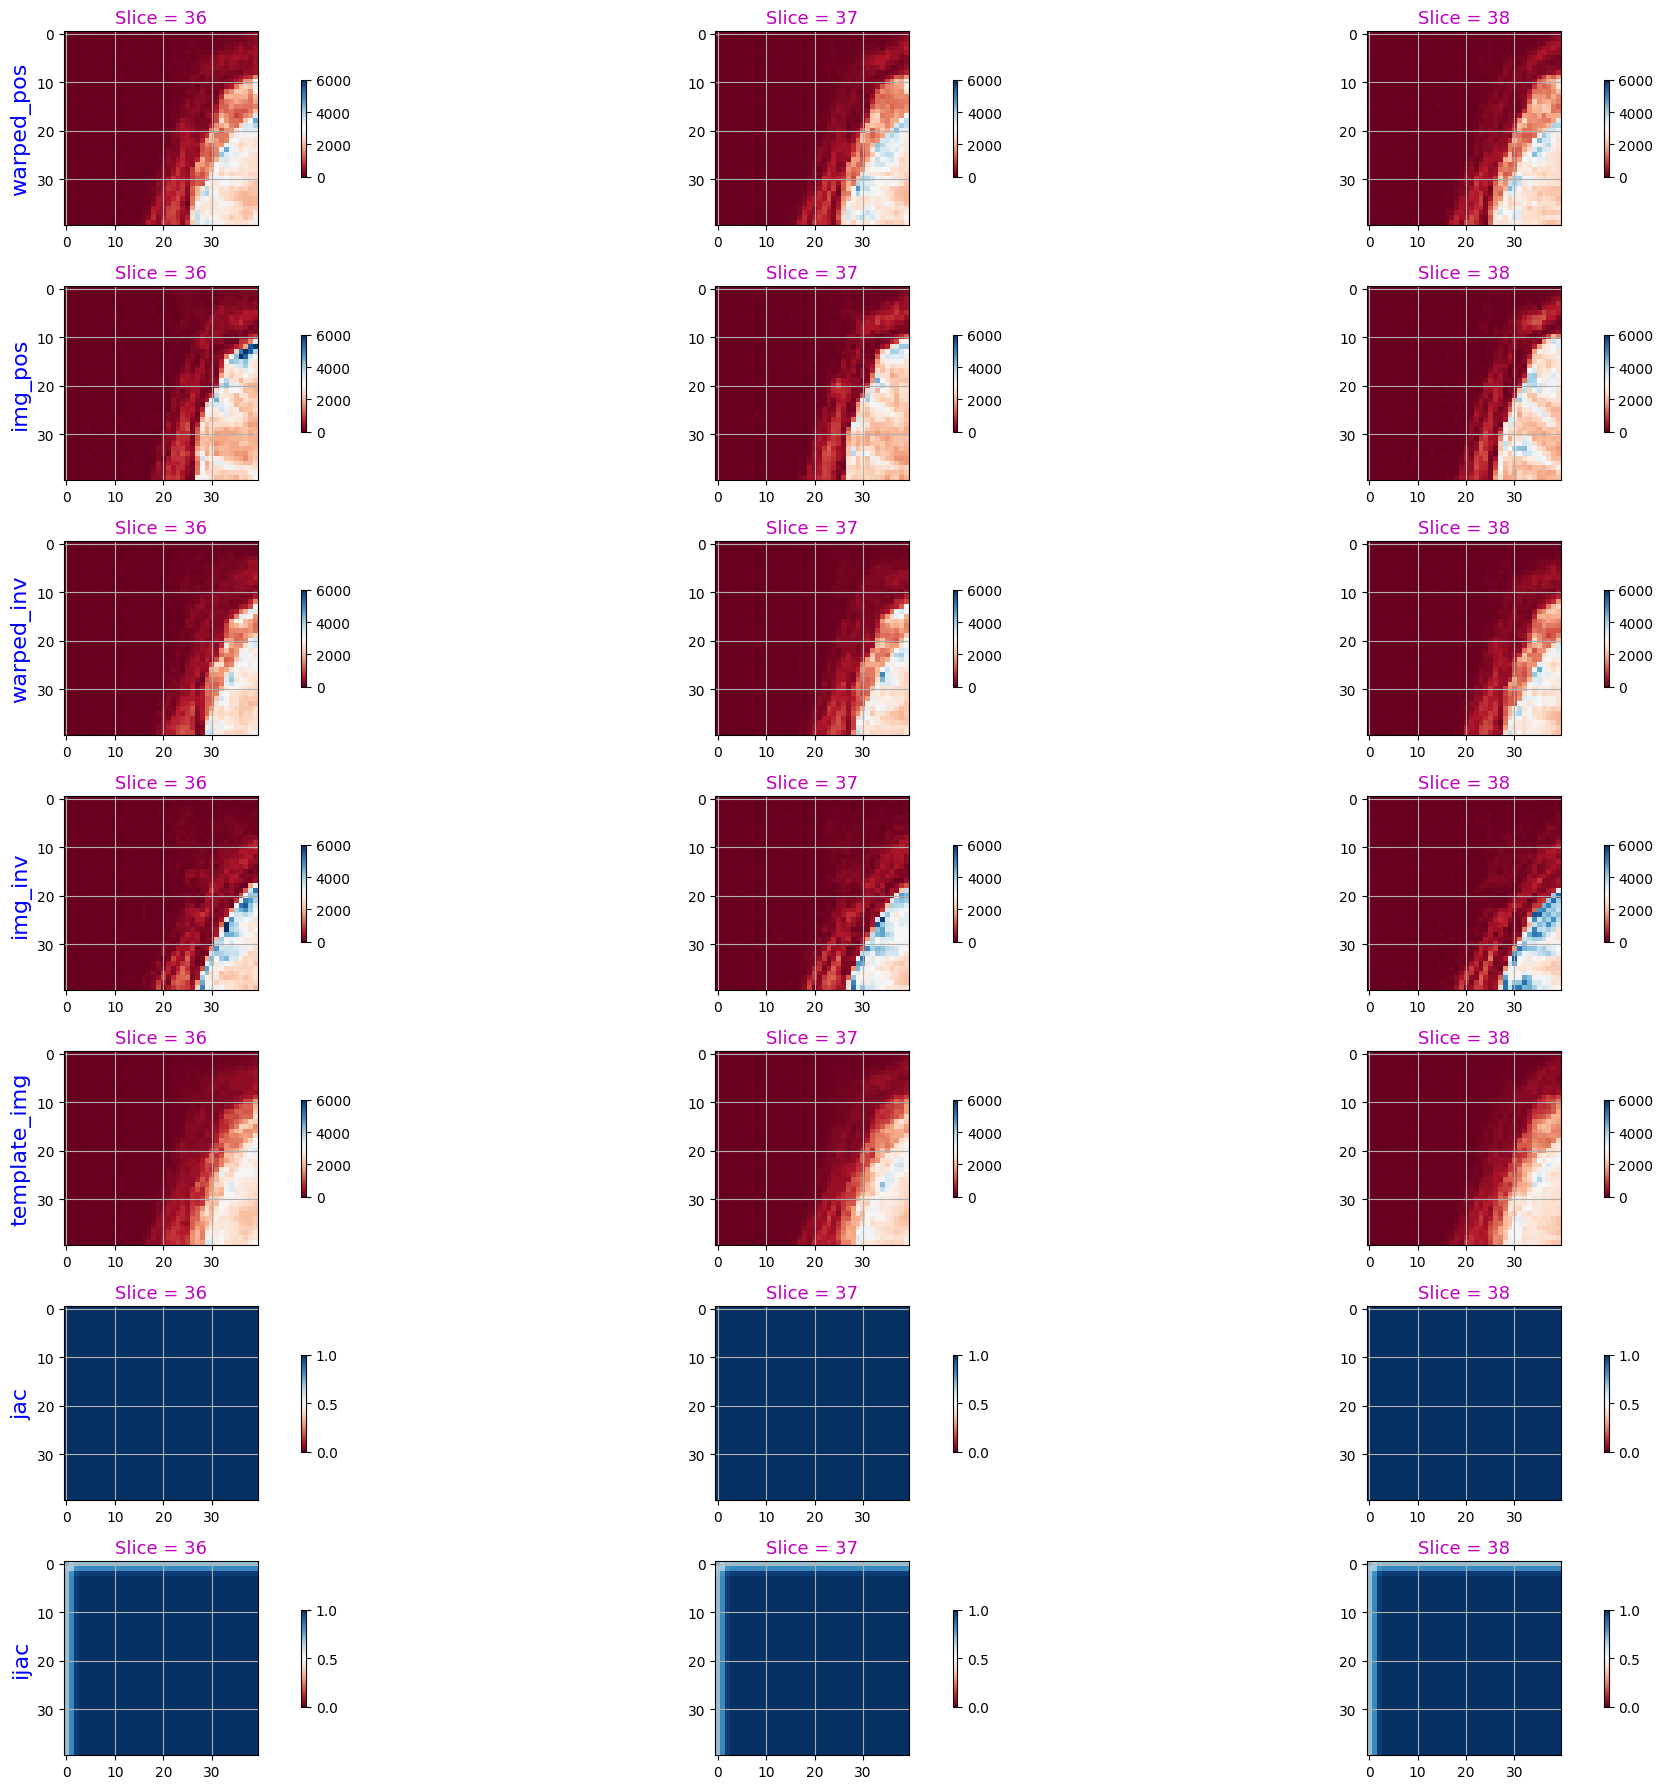

In [8]:
#Testing forward function
# test_img = (img_pos_pyramid[0][None,].to('cpu').float() + img_inv_pyramid[0][None,].to('cpu').float())/2
test_img = img_inv_pyramid[0][None,].to('cpu').float()
grid = torch.ones(1,3,76,116,116,device='cpu') 
print(test_img.shape)
# warped_pos, jac = forward_model(test_img,grid)
warped_inv, ijac = forward_model(test_img,-grid)
# print(warped_pos.shape,jac.shape,warped_pos.dtype)
t = (warped_pos+warped_inv)/2
n = 40
i = 0
z = [warped_pos.detach().cpu()[:,:,:,:n,:n], img_pos_pyramid[i].detach().cpu()[:,:,:n,:n], warped_inv.detach().cpu()[:,:,:,:n,:n], img_inv_pyramid[i].detach().cpu()[:,:,:n,:n], t.detach().cpu()[:,:,:,:n,:n], jac.detach().cpu()[:,:n,:n], ijac.detach().cpu()[:,:n,:n]]


vmax_list = [6000,6000,6000,6000,6000,1,1]
v_list = ["warped_pos", "img_pos", "warped_inv", "img_inv","template_img","jac","ijac"]
h_list = ["magnitude", "magnitude", "magnitude", "magnitude","magnitude","log","log"]
slices = [36,37,38]
plt_images_2(slices,z,v_list,h_list,vmax_list)